In [0]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [0]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, roc_curve,  roc_auc_score, classification_report
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.datasets import imdb

from keras import Sequential
from keras.layers import Embedding, Dense, LSTM, Dropout, SpatialDropout1D, SimpleRNN
from keras.callbacks import ModelCheckpoint
import os
import numpy as np

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import gensim.models.keyedvectors as word2vec
from keras.datasets import imdb

from numpy.random import seed
seed(1)

Download dos dados do word2vec 
*Disponível* em https://code.google.com/archive/p/word2vec/

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"id_de_seu_arquivo"})   # replace the id with id of file you want to access
downloaded.GetContentFile('GoogleNews-vectors-negative300.bin.gz')        # replace the file name with your file


**Carregar modelo de word embeddings word2vec**

In [0]:
w2vModel = word2vec.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True, limit=10000)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


**Carregar IMDB dataset** 

25mil instâncias preprocessadas

In [0]:
nwords = 10e5
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=nwords)

In [0]:
max_len=100
X_train = pad_sequences(x_train, maxlen=max_len, padding='post' )
X_test = pad_sequences(x_valid, maxlen=max_len, padding='post')

In [0]:
sequence = [[1], [2, 3], [4, 5, 6]]
print(sequence)
print(tf.keras.preprocessing.sequence.pad_sequences(sequence, padding='post', maxlen=2))


[[1], [2, 3], [4, 5, 6]]
[[1 0]
 [2 3]
 [5 6]]


 Média de tamanho das reviews 238.71364
 Desvio padrãão do tamanho das reviews 176.49367364852034


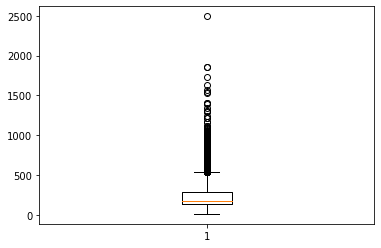

In [0]:
text_len = [len(x_train[i]) for i in range(len(x_train))]
print(" Média de tamanho das reviews", np.mean(text_len))
print(" Desvio padrãão do tamanho das reviews", np.std(text_len))
plt.boxplot(text_len)
plt.show()

In [0]:
data_id= imdb.get_word_index()

word_and_index={i: word for word, i in data_id.items()}
review_words= [word_and_index.get(i, ' ') for i in x_train[0]]
print(review_words)

['the', 'as', 'you', 'with', 'out', 'themselves', 'powerful', 'lets', 'loves', 'their', 'becomes', 'reaching', 'had', 'journalist', 'of', 'lot', 'from', 'anyone', 'to', 'have', 'after', 'out', 'atmosphere', 'never', 'more', 'room', 'titillate', 'it', 'so', 'heart', 'shows', 'to', 'years', 'of', 'every', 'never', 'going', 'villaronga', 'help', 'moments', 'or', 'of', 'every', 'chest', 'visual', 'movie', 'except', 'her', 'was', 'several', 'of', 'enough', 'more', 'with', 'is', 'now', 'current', 'film', 'as', 'you', 'of', 'mine', 'potentially', 'unfortunately', 'of', 'you', 'than', 'him', 'that', 'with', 'out', 'themselves', 'her', 'get', 'for', 'was', 'camp', 'of', 'you', 'movie', 'sometimes', 'movie', 'that', 'with', 'scary', 'but', 'pratfalls', 'to', 'story', 'wonderful', 'that', 'in', 'seeing', 'in', 'character', 'to', 'of', '70s', 'musicians', 'with', 'heart', 'had', 'shadows', 'they', 'of', 'here', 'that', 'with', 'her', 'serious', 'to', 'have', 'does', 'when', 'from', 'why', 'what', 

In [0]:
embeddings_index = {}
for w in w2vModel.wv.vocab.keys():
    embeddings_index[w] = w2vModel.wv[w]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
num_words = 10000
embedding_matrix = np.zeros((num_words, 300))
for word, i in imdb.get_word_index().items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

**Funções de avaliação dos modelos**

In [0]:
import pandas as pd
import seaborn as sn

def plot_confusion_matrix(y_pred, y_valid):
  #Other accuracy metrices
  y_pred = (y_pred > 0.5)

  #confusion metrix
  cm = pd.DataFrame(confusion_matrix(y_valid, y_pred))
  sn.heatmap(cm)

  #F1 Score, Recall and Precision
  print(classification_report(y_valid, y_pred, target_names=['Positive', 'Negative']))



In [0]:
#ROC AUC curve
def create_roc(y_valid, y_pred):
  rocAuc = roc_auc_score(y_valid, y_pred)
  print(rocAuc)
  falsePositiveRate, truePositiveRate, _ = roc_curve(y_valid, y_pred)

  plt.figure()

  plt.plot(falsePositiveRate, truePositiveRate, color='green',
          lw=3, label='ROC curve (area = %0.2f)' % rocAuc)
  plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic of Sentiiment Analysis Model')
  plt.legend(loc="lower right")
  plt.show()

In [0]:
def plot_model_certainty(y_pred):
  plt.hist(y_pred)
  _ = plt.axvline(x=0.5, color='orange')

**Training model**

Arquitetura

In [0]:
def create_model(embedding, main_nn):
  model = Sequential()
  model.add(embedding)
  model.add(SpatialDropout1D(0.2))
  model.add(main_nn)
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [0]:
#simpleRNN
embedding = Embedding(input_dim=10000, output_dim=64, input_length=100)
main_nn = SimpleRNN(128, dropout=0.2)
model = create_model(embedding, main_nn)
model.summary()

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_63 (Embedding)     (None, 100, 64)           640000    
_________________________________________________________________
spatial_dropout1d_14 (Spatia (None, 100, 64)           0         
_________________________________________________________________
simple_rnn_28 (SimpleRNN)    (None, 128)               24704     
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 129       
Total params: 664,833
Trainable params: 664,833
Non-trainable params: 0
_________________________________________________________________


In [0]:
outputdir = 'modeloutput/simplernn'
modelcheckpoint = ModelCheckpoint(filepath=outputdir+'/weights.{epoch:02d}.hdf5')
if not os.path.exists(outputdir):
  os.makedirs(outputdir)

In [0]:
result= model.fit(X_train, y_train, batch_size=256, epochs=5, validation_data=(X_test, y_valid), callbacks=[modelcheckpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 16s 623us/step - loss: 0.6810 - accuracy: 0.5546 - val_loss: 0.6422 - val_accuracy: 0.6340
Epoch 2/5
25000/25000 [==============================] - 15s 610us/step - loss: 0.4795 - accuracy: 0.7729 - val_loss: 0.3830 - val_accuracy: 0.8362
Epoch 3/5
25000/25000 [==============================] - 15s 603us/step - loss: 0.3111 - accuracy: 0.8739 - val_loss: 0.4296 - val_accuracy: 0.8049
Epoch 4/5
25000/25000 [==============================] - 15s 603us/step - loss: 0.2402 - accuracy: 0.9080 - val_loss: 0.3750 - val_accuracy: 0.8403
Epoch 5/5
25000/25000 [==============================] - 15s 604us/step - loss: 0.1762 - accuracy: 0.9359 - val_loss: 0.4269 - val_accuracy: 0.8407


In [0]:
model.load_weights(outputdir+'/weights.05.hdf5')

In [0]:
y_pred = model.predict_proba(X_test)

0.9122037087999999


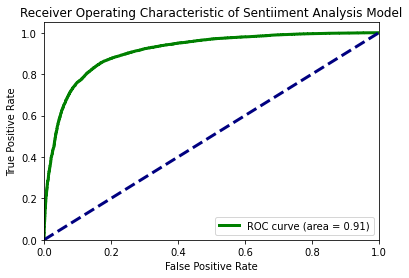

In [0]:
create_roc(y_valid, y_pred)

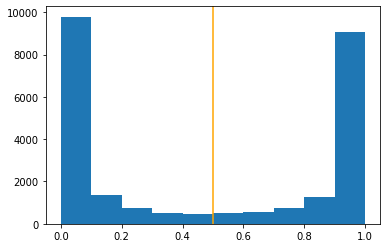

In [0]:
plot_model_certainty(y_pred)

              precision    recall  f1-score   support

    Positive       0.83      0.85      0.84     12500
    Negative       0.85      0.83      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



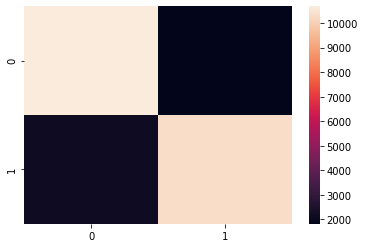

In [0]:
plot_confusion_matrix(y_pred, y_valid)

**SimpleRNN com embedding**

In [0]:
#simpleRNN com embedding
outputdir = 'modeloutput/simplernn_emb'
modelcheckpoint = ModelCheckpoint(filepath=outputdir+'/weights.{epoch:02d}.hdf5')
if not os.path.exists(outputdir):
  os.makedirs(outputdir)

embedding = Embedding(input_dim=w2vModel.syn0.shape[0], 
                            output_dim=w2vModel.syn0.shape[1], 
                            weights=[embedding_matrix], 
                            input_length=X_train.shape[1])
main_nn = SimpleRNN(256,dropout=0.2)
model = create_model(embedding, main_nn)
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_65 (Embedding)     (None, 100, 300)          3000000   
_________________________________________________________________
simple_rnn_30 (SimpleRNN)    (None, 256)               142592    
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 257       
Total params: 3,142,849
Trainable params: 3,142,849
Non-trainable params: 0
_________________________________________________________________


In [0]:
result= model.fit(X_train, y_train, batch_size=256, epochs=5, validation_data=(X_test, y_valid), callbacks=[modelcheckpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 17s 675us/step - loss: 0.6675 - accuracy: 0.5822 - val_loss: 0.6447 - val_accuracy: 0.6084
Epoch 2/5
25000/25000 [==============================] - 16s 648us/step - loss: 0.5796 - accuracy: 0.6945 - val_loss: 0.5949 - val_accuracy: 0.6653
Epoch 3/5
25000/25000 [==============================] - 16s 635us/step - loss: 0.4459 - accuracy: 0.7946 - val_loss: 0.5924 - val_accuracy: 0.6868
Epoch 4/5
25000/25000 [==============================] - 16s 638us/step - loss: 0.3896 - accuracy: 0.8251 - val_loss: 0.6583 - val_accuracy: 0.6646
Epoch 5/5
25000/25000 [==============================] - 16s 621us/step - loss: 0.4183 - accuracy: 0.7992 - val_loss: 0.7022 - val_accuracy: 0.6502


In [0]:
model.load_weights(outputdir+'/weights.05.hdf5')
y_pred = model.predict_proba(X_test)

0.7204006623999999


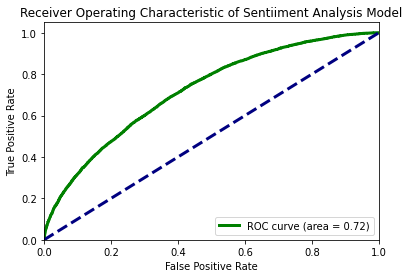

In [0]:
create_roc(y_valid, y_pred)

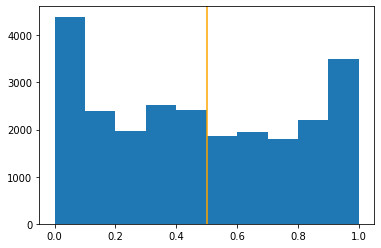

In [0]:
plot_model_certainty(y_pred)

              precision    recall  f1-score   support

    Positive       0.64      0.70      0.67     12500
    Negative       0.67      0.60      0.63     12500

    accuracy                           0.65     25000
   macro avg       0.65      0.65      0.65     25000
weighted avg       0.65      0.65      0.65     25000



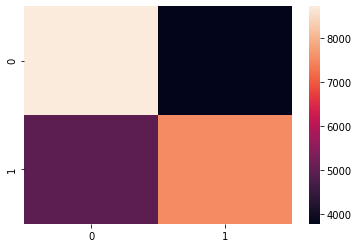

In [0]:
plot_confusion_matrix(y_pred, y_valid)

In [0]:
#LSTM com embedding
outputdir = 'modeloutput/lstm_emb'
modelcheckpoint = ModelCheckpoint(filepath=outputdir+'/weights.{epoch:02d}.hdf5')
if not os.path.exists(outputdir):
  os.makedirs(outputdir)

embedding = Embedding(input_dim=w2vModel.syn0.shape[0], 
                            output_dim=w2vModel.syn0.shape[1], 
                            weights=[embedding_matrix], 
                            input_length=X_train.shape[1])
main_nn = LSTM(units=128, dropout=0.2, recurrent_dropout=0.2)
model = create_model(embedding, main_nn)
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_66 (Embedding)     (None, 100, 300)          3000000   
_________________________________________________________________
spatial_dropout1d_16 (Spatia (None, 100, 300)          0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 129       
Total params: 3,219,777
Trainable params: 3,219,777
Non-trainable params: 0
_________________________________________________________________


In [0]:
result= model.fit(X_train, y_train, batch_size=256, epochs=20, validation_data=(X_test, y_valid), callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 36s 1ms/step - loss: 0.2202 - accuracy: 0.9167 - val_loss: 0.4076 - val_accuracy: 0.8440
Epoch 2/20
25000/25000 [==============================] - 36s 1ms/step - loss: 0.2074 - accuracy: 0.9223 - val_loss: 0.4018 - val_accuracy: 0.8385
Epoch 3/20
25000/25000 [==============================] - 35s 1ms/step - loss: 0.1902 - accuracy: 0.9299 - val_loss: 0.4148 - val_accuracy: 0.8328
Epoch 4/20
25000/25000 [==============================] - 35s 1ms/step - loss: 0.1657 - accuracy: 0.9408 - val_loss: 0.4346 - val_accuracy: 0.8391
Epoch 5/20
25000/25000 [==============================] - 35s 1ms/step - loss: 0.1385 - accuracy: 0.9525 - val_loss: 0.5380 - val_accuracy: 0.8348
Epoch 6/20
25000/25000 [==============================] - 36s 1ms/step - loss: 0.1240 - accuracy: 0.9565 - val_loss: 0.4837 - val_accuracy: 0.8324
Epoch 7/20
25000/25000 [==============================] - 35s 1ms/st

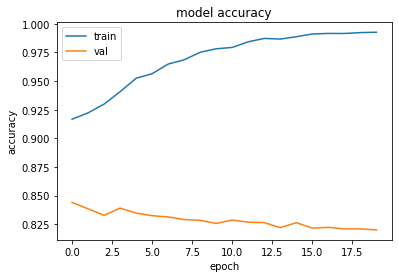

In [0]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
model.load_weights(outputdir+'/weights.05.hdf5')
y_pred = model.predict_proba(X_test)

0.92204008


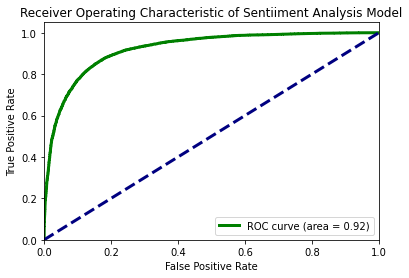

In [0]:
create_roc(y_valid, y_pred)

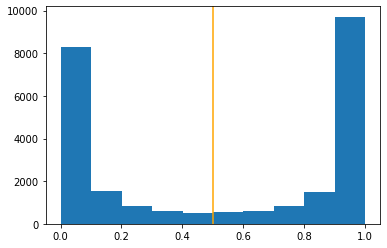

In [0]:
plot_model_certainty(y_pred)

              precision    recall  f1-score   support

    Positive       0.87      0.82      0.84     12500
    Negative       0.83      0.88      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



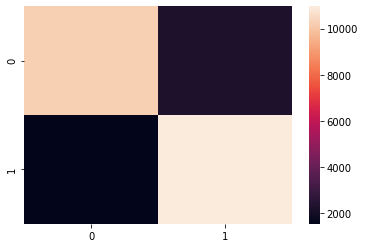

In [0]:
plot_confusion_matrix(y_pred, y_valid)